In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
df = pd.read_csv(r'\Data\Metro_Interstate_Traffic_Volume.csv')

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [5]:
holiday_le = preprocessing.LabelEncoder()
df['holiday_le'] = holiday_le.fit_transform(df['holiday']) 
weather_main_le = preprocessing.LabelEncoder()
df['weather_main_le'] = weather_main_le.fit_transform(df['weather_main']) 
weather_description_le = preprocessing.LabelEncoder()
df['weather_description_le'] = weather_description_le.fit_transform(df['weather_description']) 

In [6]:
df = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']]

In [7]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [8]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [10]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [9]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']])
dataY = y_scaler.fit_transform(df[['traffic_volume']])

In [10]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [11]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.92972555 0.         0.4        0.63636364 0.1
  0.64864865 0.76167582]
 [0.         0.93320863 0.         0.75       0.63636364 0.1
  0.05405405 0.62032967]
 [0.         0.93391815 0.         0.9        0.63636364 0.1
  0.51351351 0.65480769]
 [0.         0.93569194 0.         0.9        0.63636364 0.1
  0.51351351 0.69038462]
 [0.         0.93894927 0.         0.75       0.63636364 0.1
  0.05405405 0.67554945]
 [0.         0.94081981 0.         0.01       0.63636364 0.
  0.72972973 0.71167582]
 [0.         0.94549618 0.         0.01       0.63636364 0.
  0.72972973 0.76703297]
 [0.         0.94772148 0.         0.01       0.63636364 0.
  0.72972973 0.82623626]
 [0.         0.9486245  0.         0.2        0.63636364 0.1
  0.10810811 0.79546703]
 [0.         0.94527042 0.         0.2        0.63636364 0.1
  0.10810811 0.65521978]
 [0.         0.93840101 0.         0.2        0.63636364 0.1
  0.10810811 0.48612637]
 [0.         0.93327313 0. 

In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [13]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


In [14]:
model_path = r'\Chapter 7\Bidirectional_LSTM_Multivariate.h5'

In [15]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Train for 100 steps, validate for 50 steps
Epoch 1/150
100/100 [==============================] - 14s 140ms/step - loss: 0.1014 - val_loss: 0.0771
Epoch 2/150
100/100 [==============================] - 6s 59ms/step - loss: 0.0703 - val_loss: 0.0706
Epoch 3/150
100/100 [==============================] - 4s 39ms/step - loss: 0.0600 - val_loss: 0.0426
Epoch 4/150
100/100 [==============================] - 4s 38ms/step - loss: 0.0561 - val_loss: 0.0480
Epoch 5/150
100/100 [==============================] - 4s 38ms/step - loss: 0.0522 - val_loss: 0.0457
Epoch 6/150
100/100 [==============================] - 4s 40ms/step - loss: 0.0504 - val_loss: 0.0407
Epoch 7/150
100/100 [==============================] - 4s 39ms/step - loss: 0.0495 - val_loss: 0.0339
Epoch 8/150
100/100 [==============================] - 4s 38ms/step - loss: 0.0475 - val_loss: 0.0397
Epoch 9/150
100/100 [==============================] - 4s 38ms/step - loss: 0.0425 - val_loss: 0.0524
Epoch 10/150
100/100 [===============

In [16]:
Trained_model = tf.keras.models.load_model(model_path)

In [17]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 300)           190800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 333,430
Trainable params: 333,430
Non-trainable params: 0
_________________________________________________________________


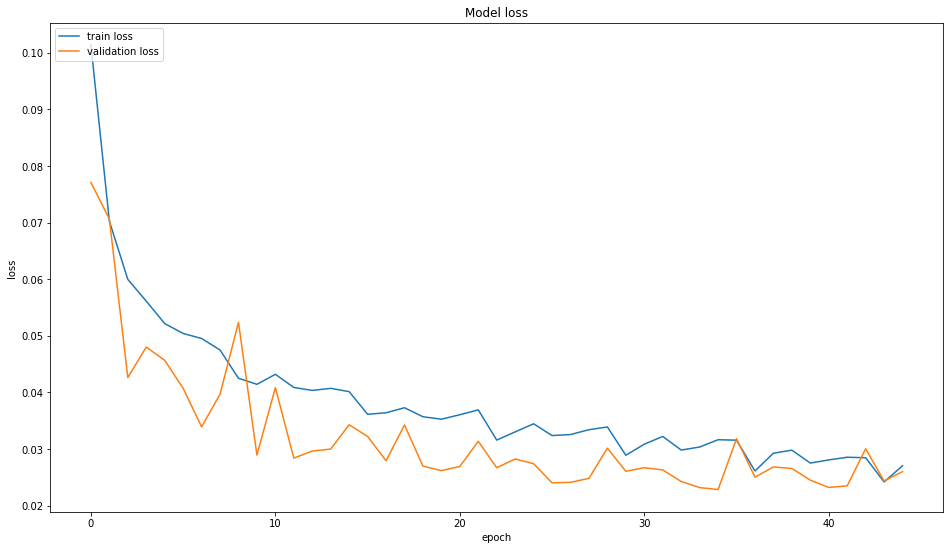

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [20]:
data_val = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(48))

In [21]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [22]:
Predicted_results = Trained_model.predict(val_rescaled)

In [23]:
Predicted_results

array([[0.6872767 , 0.6792697 , 0.6635181 , 0.6481182 , 0.614769  ,
        0.5839548 , 0.5738882 , 0.54988813, 0.5299208 , 0.5104541 ]],
      dtype=float32)

In [24]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [25]:
Predicted_results_Inv_trans

array([[5003.3745, 4945.083 , 4830.4116, 4718.3003, 4475.518 , 4251.191 ,
        4177.906 , 4003.1855, 3857.8235, 3716.106 ]], dtype=float32)

In [26]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [29]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 2110896.449748737
MAE is : 1212.5899169921875
RMSE is : 1452.8924425946805
MAPE is : 68.28356050566356
R2 is : -0.45477972355275



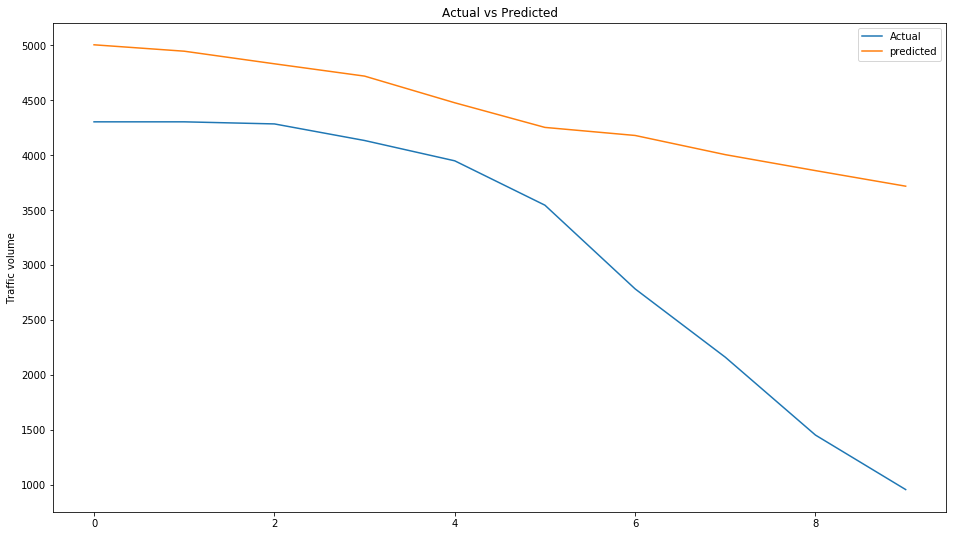

In [28]:
plt.plot( list(validate['traffic_volume']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()